## Analysis of Sales data

### Dataset

The given dataset contains monthly total sales of a company for the period 2013-2016.

### Ojectives

1. To analyse the sales and understand the performance of the company.
2. Find patterns and construct a model to forecast future sales.


### Load sales data and create visualization

In [53]:
from time_series import TimeSeries

# Imports for data visualization
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from matplotlib.dates import DateFormatter
from matplotlib import dates as mpld

register_matplotlib_converters()



Sales Data
               sales
count      48.000000
mean    47858.351667
std     25221.124187
min      4519.890000
25%     29790.100000
50%     39339.515000
75%     65833.345000
max    118447.830000
Head and Tail of the time series
date
2013-01-01    14236.90
2013-02-01     4519.89
2013-03-01    55691.01
2013-04-01    28295.35
2013-05-01    23648.29
Name: sales, dtype: float64
date
2016-08-01     63120.89
2016-09-01     87866.65
2016-10-01     77776.92
2016-11-01    118447.83
2016-12-01     83829.32
Name: sales, dtype: float64


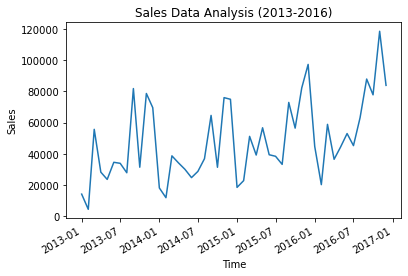

In [54]:
ts = TimeSeries('dataset/monthly_sales.csv', train_size=0.7)

print("Sales Data")
print(ts.data.describe())

print("Head and Tail of the time series")
print(ts.data.head(5).iloc[:,1])
print(ts.data.tail(5).iloc[:,1])

# Plot of raw time series data
plt.plot(ts.data.index,ts.data.sales)
plt.gcf().autofmt_xdate()
date_format = mpld.DateFormatter('%Y-%m')
plt.gca().xaxis.set_major_formatter(date_format)
plt.title("Sales Data Analysis (2013-2016)")
plt.xlabel("Time")
plt.ylabel("Sales")
plt.show()

### Seasonal Decompose of the time series

Seasonal decompose is a method used to decompose the components of a time series into the following:
- Level - average value in the series.
- Trend - increasing or decreasing value in the series.
- Seasonality - repeating short-term cycle in the series.
- Noise - random variation in the series.

The analysis of the components individually provide better insights for model selection.

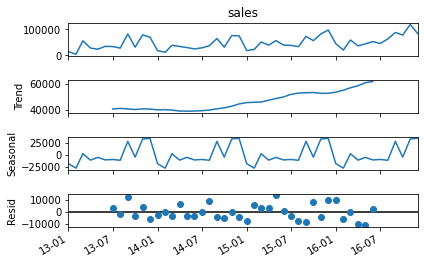

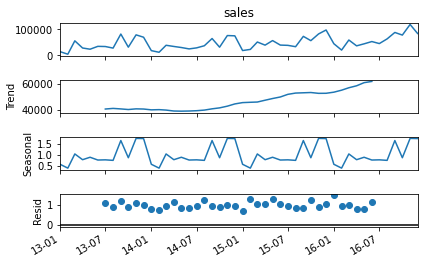

In [55]:
from statsmodels.tsa.seasonal import seasonal_decompose

result_add = seasonal_decompose(ts.data.iloc[:,1],period=12,model='additive')
result_add.plot()
plt.gcf().autofmt_xdate()
date_format = mpld.DateFormatter('%y-%m')
plt.gca().xaxis.set_major_formatter(date_format)

result_mul = seasonal_decompose(ts.data.iloc[:,1],period=12,model='multiplicative')
result_mul.plot()
plt.gcf().autofmt_xdate()
date_format = mpld.DateFormatter('%y-%m')
plt.gca().xaxis.set_major_formatter(date_format)
plt.show()


### Observation from Seasonal Decompose

1. The time series seems to roughly have a constant seasonality but has an overall **increasing trend**
2. The slight descreasing trend is observed till 2014-07 after that an increasing trend is observed.

### Model Selection
From the above observation we can evidently conclude that **Holt-Winter additive model** would be an appropriate choice as there is a constant seasonality component along with an increasing trend.
